# Data Analysis - Trends of Sports Market in Istanbul and Predicting the Next Trend

Individual sports become more and more popular all over the globe due to raise of the self awareness and well-being philosophy is spreading among people.

#### The Problem
As a result, many disciplines of sports become more and more popular. However, **not all of them become more popular and almost none of them can keep itself as the most preferred one.**

In this report, you will find an analysis of sports market in Istanbul, more specifically, Kadikoy and Besiktas Towns and an prediction for an upcoming trend if possible.

#### The Interest

The results of this report may give a deeper insight to the investors planning to found a business targeting the sports market around the Istanbul and in other regions.

# Data Collection

The Data is collected in the [data gathering notebook](https://github.com/resatcaner/Coursera_Capstone/blob/master/Data_Gathering.ipynb). 

- Kadikoy and Besiktas are one of the towns in Istanbul and Turkey that is one of the highest cultural and financial levels in Turkey. This makes them a great candidate to inpect the trends as these regions are generally flag carriers for such trends. The neighborhoods of these towns are used. The data of this collected from [Turkish Postal Office Database](https://postakodu.ptt.gov.tr/)
- Longitude and Latitude data related to the neighborhoods are collected via Google Geocoding API. 
- Venue details are collected via Foursquare Places API
- Venue details are broken into two databases of Kadikoy neighborhoods and Besiktas Neighborhoods and saved as *kadikoy_venues.csv* and *besiktas_venues.csv*

### Database Details

|Column Name|Column Detail|
|---|---|
|Venue Id| ID of venue on Foursquare|
|Neighborhood|Name of the neighborhood|
|Neighborhood Latitude|Latitude of the neighborhood|
|Neighborhood Longitude|Longitude of the neighborhood|
|Venue|Name of the venue|
|Venue Latitude|Latitude of the venue|
|Venue Longitude|Latitude of the venue|
|Venue Distance|The distance in between the venue and the neighborhood center|
|Venue Category|The category of the venue on Foursquare|
|Venue Url|The url of the venue homepage on Foursquare|
|Venue Twitter|The recorded twitter account of the venue on Foursquare|
|Venue Instagram|The recorded instagram account of the venue on Foursquare|
|Venue Formatted Phone|The recorded phone number of the venue on Foursquare|
|Venue Rating|The rating of the venue on Foursquare|
|Venue Description|The description of the venue on Foursquare|
|Venue Created|Venue creation date on Foursquare in Epoch|
|Venue Tips Count|The number of tips of the venue on Foursquare|
|Venue Likes Count|The number of likes of the venue on Foursquare|

-----

# Exploratory Analysis

Lets use the *Venue Created* feature of the dataset to see the trends

In [1]:
#importing essential libraries
%matplotlib inline

import pandas as pd
import numpy as np # library to handle data in a vectorized manner
import datetime
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# import modelling libraries
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.ticker as mtick
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import folium # map rendering library

In [2]:
# importing the data to the dataframes

kadikoy_venues=pd.read_csv('kadikoy_venues.csv')
besiktas_venues=pd.read_csv('besiktas_venues.csv')

print('Number of venues in Kadikoy is {}'.format(len(kadikoy_venues.index)))
print('Number of venues in Besiktas is {}'.format(len(besiktas_venues.index)))

Number of venues in Kadikoy is 553
Number of venues in Besiktas is 492


### All_venues dataframe will be created for a general overview

In [3]:
kadikoy_venues['Town']='Kadikoy'
besiktas_venues['Town']='Besiktas'
all_venues = pd.concat([kadikoy_venues,besiktas_venues])

In [4]:
print('Number of total venues is {}'.format(len(all_venues.index)))
print(all_venues.dtypes)

Number of total venues is 1045
Venue Id                   object
Neighborhood               object
Neighborhood Latitude     float64
Neighborhood Longitude    float64
Venue                      object
Venue Latitude            float64
Venue Longitude           float64
Venue Distance              int64
Venue Category             object
Venue Url                  object
Venue Twitter              object
Venue Instagram           float64
Venue Formatted Phone      object
Venue Rating              float64
Venue Description          object
Venue Created               int64
Venue Tips Count            int64
Venue Likes Count           int64
Town                       object
dtype: object


In [5]:
all_venues.describe(include=['object'])

,Venue Id,Neighborhood,Venue,Venue Category,Venue Url,Venue Twitter,Venue Formatted Phone,Venue Description,Town
count,1045,1045,1045,1045,98,65,189,13,1045
unique,1045,44,1009,13,87,57,168,13,2
top,5b156df4b9a5a8002c157540,Caddebostan mah,Gym,Gym,http://www.fitintime.com.tr,fitintime,+90 216 355 78 43,"Sağlıklı yaşam, zinde bir vücut için ''GYM wo...",Kadikoy
freq,1,47,6,431,5,5,4,1,553


### Let's see how many venues we have in each category

In [6]:
category_counts = all_venues['Venue Category'].value_counts().to_frame()
category_counts.rename(columns={'Venue Category': 'Count'}, inplace=True)
category_counts.index.name = 'Venue Type'
category_counts

,Count
Venue Type,
Gym,431
Gym / Fitness Center,315
Yoga Studio,114
Pilates Studio,77
Martial Arts Dojo,51
Gym Pool,18
Gymnastics Gym,13
Track,8
Boxing Gym,6


### Let's check when the first and last venue is created

In [7]:
print('First venue was created on {}'.format(datetime.datetime.fromtimestamp(all_venues['Venue Created'].min()).strftime('%d.%m.%Y %H:%M:%S')))
print('Last venue was created on {}'.format(datetime.datetime.fromtimestamp(all_venues['Venue Created'].max()).strftime('%d.%m.%Y %H:%M:%S')))

First venue was created on 01.02.2010 15:20:37
Last venue was created on 25.06.2020 16:36:40


### We will check here the distribution of venue opening dates

Foursquare is (or was) a popular app and cared about venue owners. Therefore the venue creation dates are assumed as the venue opening dates as it is expected the venue owner to register the property on Foursquare asap.

In [8]:
#Binning the created dates for approximately 6 months 
bins=np.linspace(all_venues['Venue Created'].min(), all_venues['Venue Created'].max(), 24)
bins

array([1.26503764e+09, 1.27930135e+09, 1.29356506e+09, 1.30782877e+09,
       1.32209248e+09, 1.33635619e+09, 1.35061991e+09, 1.36488362e+09,
       1.37914733e+09, 1.39341104e+09, 1.40767475e+09, 1.42193846e+09,
       1.43620217e+09, 1.45046589e+09, 1.46472960e+09, 1.47899331e+09,
       1.49325702e+09, 1.50752073e+09, 1.52178444e+09, 1.53604815e+09,
       1.55031187e+09, 1.56457558e+09, 1.57883929e+09, 1.59310300e+09])

In [9]:
counts=[]
tempbin=0
#temp df for the iteration with category and creation date
encoding=all_venues[['Venue Category','Venue Created']]
encond=pd.DataFrame(columns=all_venues['Venue Category'].unique())
encond['bin']=()
# binning for each value row and find number of categories by setting the end date as the limit for the row
for bin_no in bins[1:]:
    encond = encond.append({'bin': datetime.datetime.fromtimestamp(bin_no).strftime('%d.%m.%Y')}, ignore_index=True)
    for cat in all_venues['Venue Category'].unique():
        encond.loc[encond['bin']==datetime.datetime.fromtimestamp(bin_no).strftime('%d.%m.%Y'),[cat]]= len(encoding.loc[(encoding['Venue Created'] <= bin_no) & (encoding['Venue Created'] > tempbin) & (encoding['Venue Category'] == cat), ['Venue Category']])
    tempbin=bin_no

### We got the data encoded in a new df 'encond'

In [10]:
encond.head()

,Gym,Gym / Fitness Center,Track,Yoga Studio,Martial Arts Dojo,Gym Pool,Pilates Studio,Gymnastics Gym,Cycle Studio,Boxing Gym,Outdoor Gym,Weight Loss Center,Climbing Gym,bin
0,7,5,0,0,0,0,0,0,0,0,0,0,0,16.07.2010
1,8,18,0,2,0,2,0,0,0,0,0,0,0,28.12.2010
2,26,18,2,16,1,0,0,0,0,0,0,0,0,11.06.2011
3,30,19,0,15,3,3,0,0,0,0,0,0,0,23.11.2011
4,26,11,2,6,5,1,0,0,0,0,0,0,0,07.05.2012


### Here is the cumulative graphics to overview the trends

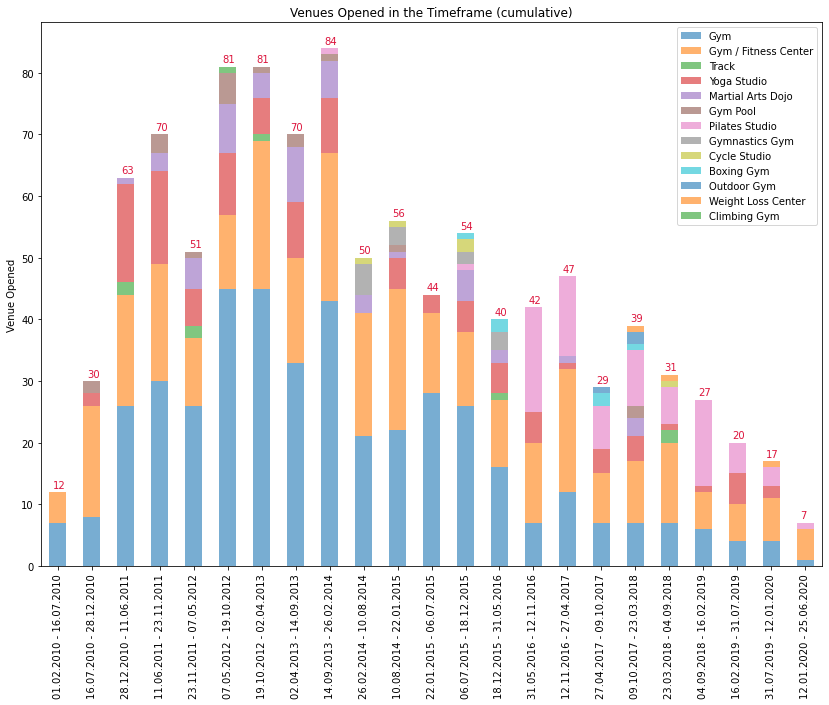

In [11]:
fig, ax = plt.subplots()
encond.plot(kind='bar',stacked=True,ax=ax,figsize=(14, 10), alpha=0.6)

xlabels=[]
for i in range (len(bins)-1):
    xlabels.append(datetime.datetime.fromtimestamp(bins[i]).strftime('%d.%m.%Y')+' - '+datetime.datetime.fromtimestamp(bins[i+1]).strftime('%d.%m.%Y'))

ax.set_ylabel('Venue Opened')
ax.set_title('Venues Opened in the Timeframe (cumulative)')
ax.set_xticklabels(xlabels)
j=0
for i in encond[all_venues['Venue Category'].unique()].sum(axis=1): 
    # lets place total venue opened count at the top of the bar
    plt.annotate(int(i), xy=(j-0.15, i+0.7), color='crimson')
    j=j+1

ax.legend()

plt.show()

### Lets see the comparison
First, lets do the encondings for visualization

In [12]:
#KADIKOY
bins_kadikoy=np.linspace(kadikoy_venues['Venue Created'].min(), kadikoy_venues['Venue Created'].max(), 24)
counts=[]
tempbin=0
#temp df for the iteration with category and creation date
encoding=kadikoy_venues[['Venue Category','Venue Created']]
encond_kadikoy=pd.DataFrame(columns=all_venues['Venue Category'].unique())
encond_kadikoy['bin']=()
# binning for each value row and find number of categories by setting the end date as the limit for the row
for bin_no in bins_kadikoy[1:]:
    encond_kadikoy = encond_kadikoy.append({'bin': datetime.datetime.fromtimestamp(bin_no).strftime('%d.%m.%Y')}, ignore_index=True)
    for cat in all_venues['Venue Category'].unique():
        encond_kadikoy.loc[encond_kadikoy['bin']==datetime.datetime.fromtimestamp(bin_no).strftime('%d.%m.%Y'),[cat]]= len(encoding.loc[(encoding['Venue Created'] <= bin_no) & (encoding['Venue Created'] > tempbin) & (encoding['Venue Category'] == cat), ['Venue Category']])
    tempbin=bin_no
    
#BESIKTAS
bins_besiktas=np.linspace(besiktas_venues['Venue Created'].min(), besiktas_venues['Venue Created'].max(), 24)
counts=[]
tempbin=0
#temp df for the iteration with category and creation date
encoding=besiktas_venues[['Venue Category','Venue Created']]
encond_besiktas=pd.DataFrame(columns=all_venues['Venue Category'].unique())
encond_besiktas['bin']=()
# binning for each value row and find number of categories by setting the end date as the limit for the row
for bin_no in bins_besiktas[1:]:
    encond_besiktas = encond_besiktas.append({'bin': datetime.datetime.fromtimestamp(bin_no).strftime('%d.%m.%Y')}, ignore_index=True)
    for cat in all_venues['Venue Category'].unique():
        encond_besiktas.loc[encond_besiktas['bin']==datetime.datetime.fromtimestamp(bin_no).strftime('%d.%m.%Y'),[cat]]= len(encoding.loc[(encoding['Venue Created'] <= bin_no) & (encoding['Venue Created'] > tempbin) & (encoding['Venue Category'] == cat), ['Venue Category']])
    tempbin=bin_no

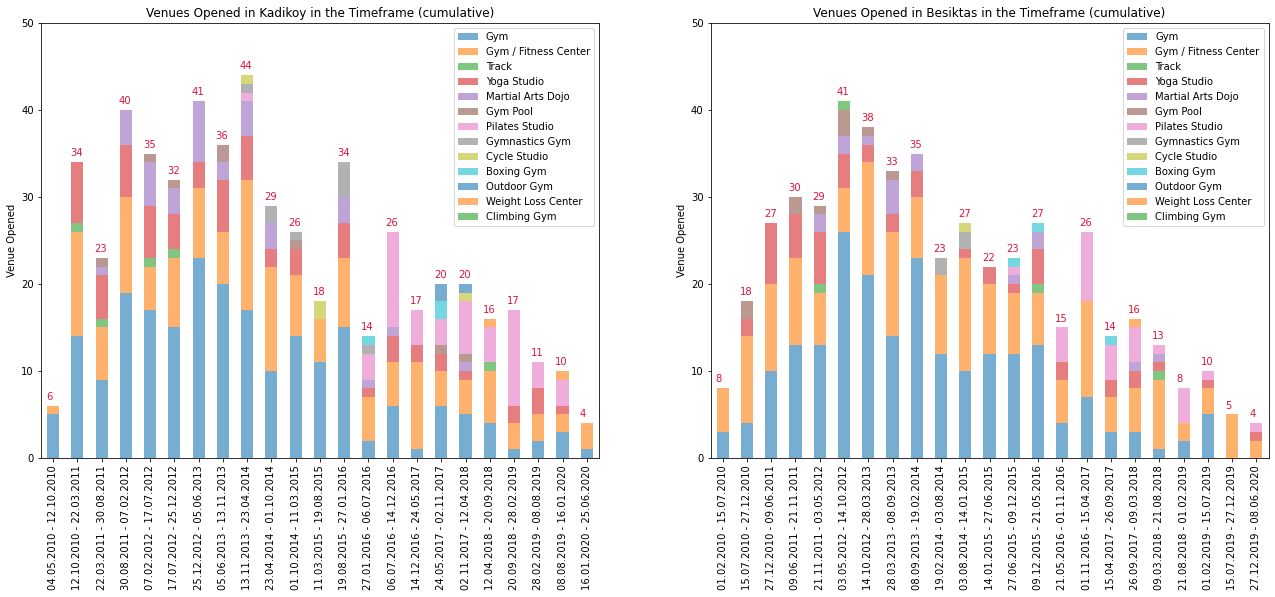

In [13]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
encond_kadikoy.plot(kind='bar',stacked=True,ax=ax0,figsize=(22, 8), alpha=0.6)

xlabels=[]
for i in range (len(bins_kadikoy)-1):
    xlabels.append(datetime.datetime.fromtimestamp(bins_kadikoy[i]).strftime('%d.%m.%Y')+' - '+datetime.datetime.fromtimestamp(bins_kadikoy[i+1]).strftime('%d.%m.%Y'))

ax0.set_ylabel('Venue Opened')
ax0.set_title('Venues Opened in Kadikoy in the Timeframe (cumulative)')
ax0.set_xticklabels(xlabels)
j=0
for i in encond_kadikoy[all_venues['Venue Category'].unique()].sum(axis=1): 
    # lets place total venue opened count at the top of the bar
    ax0.annotate(int(i), xy=(j-0.3, i+0.7), color='crimson')
    j=j+1
ax0.set_ylim(top=50)
ax0.legend()


# Subplot 2: Line plot
encond_besiktas.plot(kind='bar',stacked=True,ax=ax1,figsize=(22, 8), alpha=0.6)

xlabels=[]
for i in range (len(bins_besiktas)-1):
    xlabels.append(datetime.datetime.fromtimestamp(bins_besiktas[i]).strftime('%d.%m.%Y')+' - '+datetime.datetime.fromtimestamp(bins_besiktas[i+1]).strftime('%d.%m.%Y'))

ax1.set_ylabel('Venue Opened')
ax1.set_title('Venues Opened in Besiktas in the Timeframe (cumulative)')
ax1.set_xticklabels(xlabels)
j=0
for i in encond_besiktas[all_venues['Venue Category'].unique()].sum(axis=1): 
    # lets place total venue opened count at the top of the bar
    ax1.annotate(int(i), xy=(j-0.3, i+0.7), color='crimson')
    j=j+1
ax1.set_ylim(top=50)
ax1.legend()
plt.show()

---
## Let's compare the Towns according to the Venue Categories

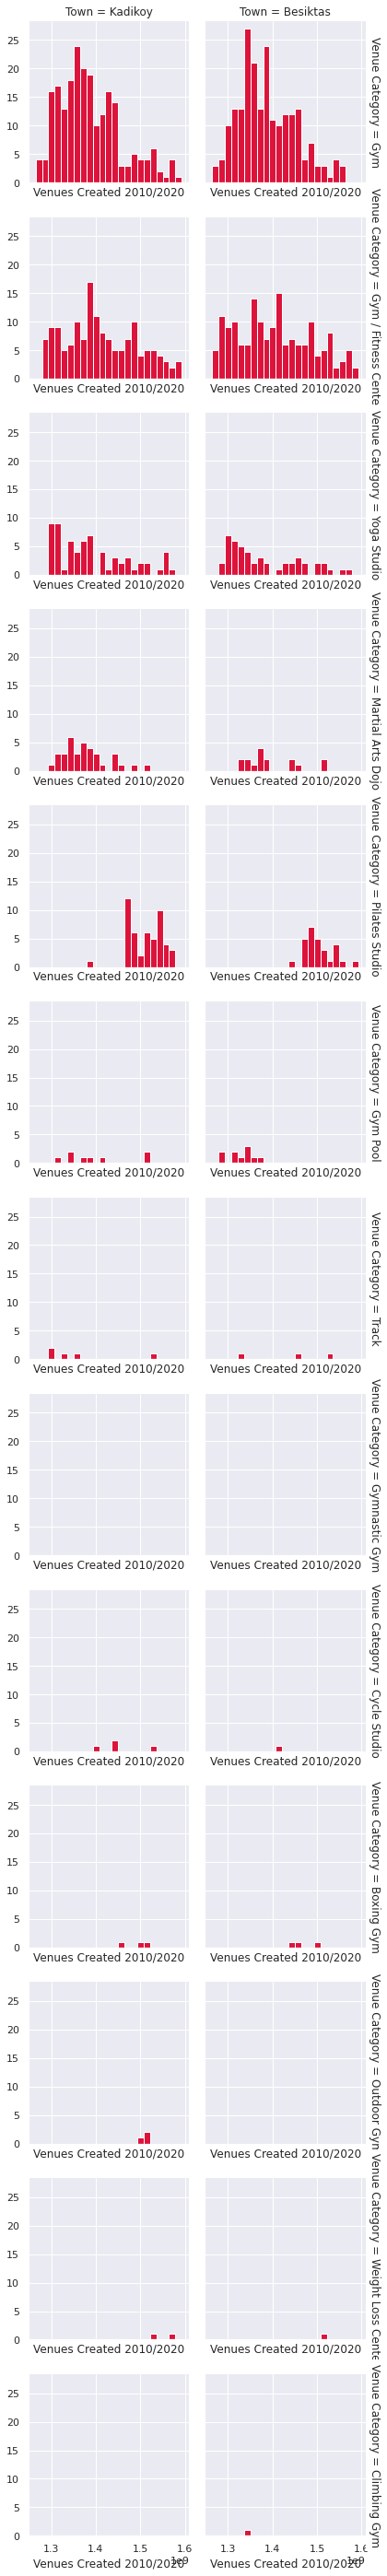

In [14]:
sns.set(style="darkgrid")

tips = sns.load_dataset("tips")
g = sns.FacetGrid(all_venues, col="Town", row="Venue Category", row_order=[
    'Gym',
    'Gym / Fitness Center',
    'Yoga Studio', 
    'Martial Arts Dojo', 
    'Pilates Studio',
    'Gym Pool',
    'Track',
    'Gymnastic Gym',
    'Cycle Studio',
    'Boxing Gym',
    'Outdoor Gym',
    'Weight Loss Center',
    'Climbing Gym'],
                  margin_titles=True)
bins=np.linspace(all_venues['Venue Created'].min(), all_venues['Venue Created'].max(), 24)
g.map(plt.hist, "Venue Created", color="crimson", bins=bins)
for ax in g.axes.flat:
    ax.set_xlabel('Venues Created 2010/2020')

## Let's see the Rating Comparison

We are going to use the facetgrid to show the distribution of ratings of the venues of each category. Ratings are user votes for the venue in between 0(worst) and 10(best)

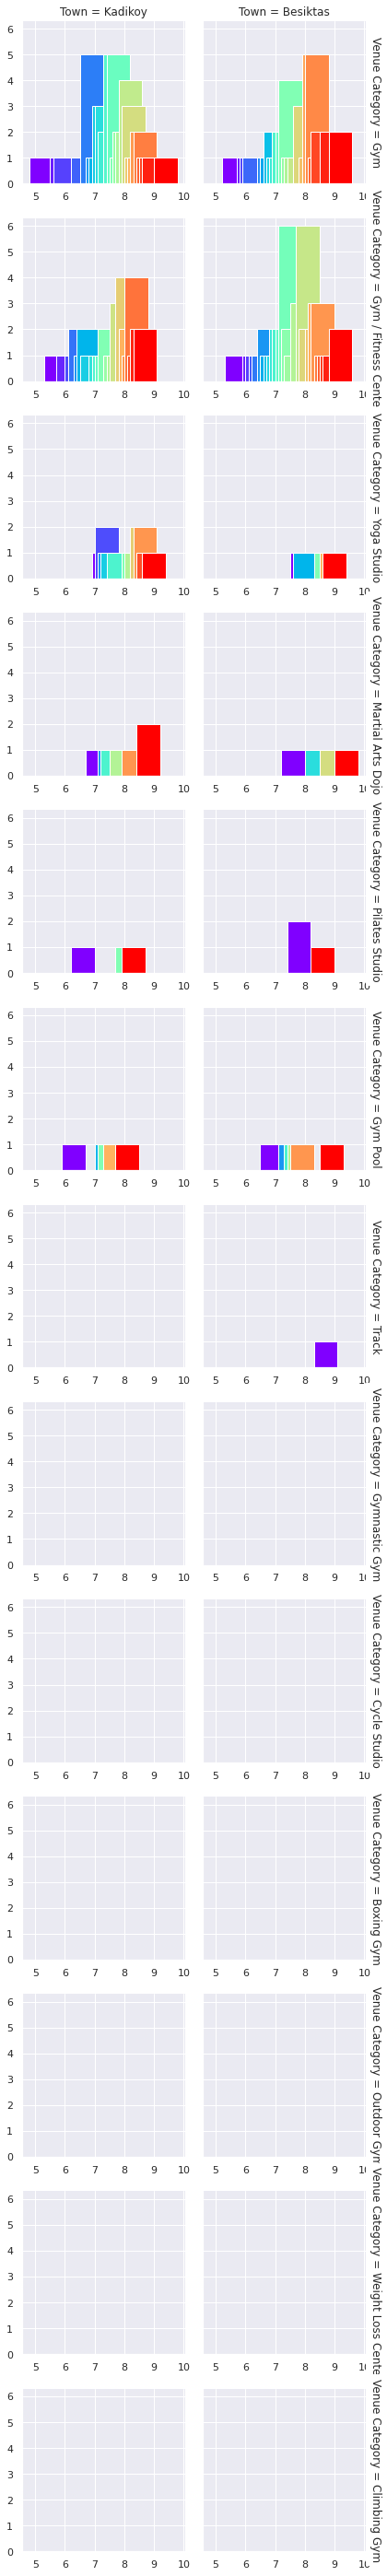

In [15]:
#defining the dataframe plotter function
def plot_rating(*args, **kwargs):
    data = kwargs.pop('data')

    rating = data['Venue Rating'].value_counts().sort_index()
    plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))

#Removing the non rated venues
df_temp=all_venues.loc[(all_venues['Venue Rating']>0.0)][['Venue Rating','Town','Venue Category']].reset_index()

#Creating the Facetgrid
g = sns.FacetGrid(df_temp, col="Town", row="Venue Category", row_order=[
    'Gym',
    'Gym / Fitness Center',
    'Yoga Studio', 
    'Martial Arts Dojo', 
    'Pilates Studio',
    'Gym Pool',
    'Track',
    'Gymnastic Gym',
    'Cycle Studio',
    'Boxing Gym',
    'Outdoor Gym',
    'Weight Loss Center',
    'Climbing Gym'],
                  margin_titles=True)
#passing parameters to reveal xticks under each axe
g.map_dataframe(plot_rating)
for ax in g.axes.flat:
    ax.tick_params(labelbottom=True)
    ax.set_xticks((5,6,7,8,9,10))
    ax.set_xticklabels(['5','6','7','8','9','10'])

## Half Time Information

On the Half way, the numbers look identical, however Kadikoy is leading for **Gym, Track, Track Yoga Studio, Martial Arts Dojo and Pilates Studio** categories whereas Besiktas is leading the **Gym / Fitness Center, Gymnastic Gym and Gym Pool** categories.

In [16]:
for types in all_venues['Venue Category'].unique():
    print('{} is the total number of {} opened in Kadikoy in between 01.02.2010 and 01.01.2015'.format(len(kadikoy_venues.loc[ (kadikoy_venues['Venue Created'] < int(datetime.datetime(2015,1,1,0,0).timestamp())) & (kadikoy_venues['Venue Category']==types)].index),types))
    print('{} is the total number of {} opened in Besiktas in between 01.02.2010 and 01.01.2015'.format(len(besiktas_venues.loc[ (besiktas_venues['Venue Created'] < int(datetime.datetime(2015,1,1,0,0).timestamp())) & (besiktas_venues['Venue Category']==types)].index),types))

156 is the total number of Gym opened in Kadikoy in between 01.02.2010 and 01.01.2015
149 is the total number of Gym opened in Besiktas in between 01.02.2010 and 01.01.2015
87 is the total number of Gym / Fitness Center opened in Kadikoy in between 01.02.2010 and 01.01.2015
100 is the total number of Gym / Fitness Center opened in Besiktas in between 01.02.2010 and 01.01.2015
4 is the total number of Track opened in Kadikoy in between 01.02.2010 and 01.01.2015
1 is the total number of Track opened in Besiktas in between 01.02.2010 and 01.01.2015
45 is the total number of Yoga Studio opened in Kadikoy in between 01.02.2010 and 01.01.2015
32 is the total number of Yoga Studio opened in Besiktas in between 01.02.2010 and 01.01.2015
29 is the total number of Martial Arts Dojo opened in Kadikoy in between 01.02.2010 and 01.01.2015
11 is the total number of Martial Arts Dojo opened in Besiktas in between 01.02.2010 and 01.01.2015
6 is the total number of Gym Pool opened in Kadikoy in between

---------------------

# Clustering the Neighborhood

In [17]:
# one hot encoding
all_venues_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
all_venues_onehot['Neighborhood'] = all_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [all_venues_onehot.columns[-1]] + list(all_venues_onehot.columns[:-1])
all_venues_onehot = all_venues_onehot[fixed_columns]

all_venues_onehot.head()

,Neighborhood,Boxing Gym,Climbing Gym,Cycle Studio,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Martial Arts Dojo,Outdoor Gym,Pilates Studio,Track,Weight Loss Center,Yoga Studio
0,Caddebostan mah,0,0,0,1,0,0,0,0,0,0,0,0,0
1,Rasi̇mpasa mah,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Feneryolu mah,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Osmanaga mah,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Caferaga mah,0,0,0,0,1,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [18]:
all_venues_grouped = all_venues_onehot.groupby('Neighborhood').mean().reset_index()
all_venues_grouped

,Neighborhood,Boxing Gym,Climbing Gym,Cycle Studio,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Martial Arts Dojo,Outdoor Gym,Pilates Studio,Track,Weight Loss Center,Yoga Studio
0,19 mayis mah,0.027778,0.000000,0.027778,0.388889,0.333333,0.000000,0.000000,0.055556,0.027778,0.055556,0.055556,0.000000,0.027778
1,Abbasaga mah,0.000000,0.000000,0.000000,0.750000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Acibadem mah,0.000000,0.000000,0.000000,0.550000,0.200000,0.000000,0.000000,0.100000,0.000000,0.150000,0.000000,0.000000,0.000000
3,Akat mah,0.000000,0.000000,0.000000,0.214286,0.428571,0.107143,0.035714,0.035714,0.000000,0.107143,0.035714,0.000000,0.035714
4,Arnavutkoy mah,0.000000,0.000000,0.000000,0.800000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Balmumcu mah,0.000000,0.000000,0.000000,0.500000,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000
6,Bebek mah,0.040000,0.000000,0.000000,0.400000,0.400000,0.000000,0.000000,0.040000,0.000000,0.040000,0.000000,0.000000,0.080000
7,Bostanci mah,0.000000,0.000000,0.000000,0.366667,0.200000,0.000000,0.033333,0.000000,0.000000,0.066667,0.000000,0.000000,0.333333
8,Caddebostan mah,0.021277,0.000000,0.042553,0.255319,0.234043,0.063830,0.000000,0.021277,0.000000,0.148936,0.000000,0.000000,0.212766
9,Caferaga mah,0.000000,0.000000,0.000000,0.261905,0.285714,0.023810,0.000000,0.095238,0.000000,0.119048,0.000000,0.000000,0.214286


In [19]:
#method to sort venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = all_venues_grouped['Neighborhood']

for ind in np.arange(all_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(all_venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,19 mayis mah,Gym,Gym / Fitness Center,Track,Pilates Studio,Martial Arts Dojo,Yoga Studio,Outdoor Gym,Cycle Studio,Boxing Gym,Weight Loss Center
1,Abbasaga mah,Gym,Gym / Fitness Center,Yoga Studio,Weight Loss Center,Track,Pilates Studio,Outdoor Gym,Martial Arts Dojo,Gymnastics Gym,Gym Pool
2,Acibadem mah,Gym,Gym / Fitness Center,Pilates Studio,Martial Arts Dojo,Yoga Studio,Weight Loss Center,Track,Outdoor Gym,Gymnastics Gym,Gym Pool
3,Akat mah,Gym / Fitness Center,Gym,Pilates Studio,Gym Pool,Yoga Studio,Track,Martial Arts Dojo,Gymnastics Gym,Weight Loss Center,Outdoor Gym
4,Arnavutkoy mah,Gym,Gym / Fitness Center,Yoga Studio,Weight Loss Center,Track,Pilates Studio,Outdoor Gym,Martial Arts Dojo,Gymnastics Gym,Gym Pool


## Let's do the clustering

In [21]:
# set number of clusters
kclusters = 8
all_venues_grouped_clustering = all_venues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(all_venues_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 4, 5, 2, 4, 0, 6, 3, 3], dtype=int32)

In [22]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

all_venues_merged = all_venues.copy()
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood

all_venues_merged = all_venues_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

all_venues_merged.head() # check the last columns!

,Venue Id,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Venue Url,Venue Twitter,Venue Instagram,Venue Formatted Phone,Venue Rating,Venue Description,Venue Created,Venue Tips Count,Venue Likes Count,Town,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4bdfd536be5120a15ec2fe70,Caddebostan mah,40.967927,29.061993,Powerfull Atlethic Club,40.967527,29.064940,251,Gym,http://caddebostan.powerfullclub.com,powerfullclub,NaN,+90 216 356 71 71,7.8,Caddebostan Kültür Merkezi’nde hizmet veren te...,1272960310,52,209,Kadikoy,3,Gym,Gym / Fitness Center,Yoga Studio,Pilates Studio,Gym Pool,Cycle Studio,Martial Arts Dojo,Boxing Gym,Weight Loss Center,Track
1,4be31013660ec9287609cb3b,Rasi̇mpasa mah,40.996066,29.027081,Sports,41.000300,29.031012,575,Gym,NaN,NaN,NaN,NaN,0.0,NaN,1273171987,0,0,Kadikoy,4,Gym,Gym / Fitness Center,Martial Arts Dojo,Yoga Studio,Pilates Studio,Gym Pool,Weight Loss Center,Track,Outdoor Gym,Gymnastics Gym
2,4be4544d2468c928419dfe42,Feneryolu mah,40.981957,29.048902,Eaglestar Fitness and Body Form Club,40.978751,29.047985,365,Gym,NaN,NaN,NaN,NaN,8.1,NaN,1273254989,11,57,Kadikoy,3,Gym,Yoga Studio,Gym / Fitness Center,Pilates Studio,Weight Loss Center,Track,Outdoor Gym,Martial Arts Dojo,Gymnastics Gym,Gym Pool
3,4bf78371bb5176b0c3385bb2,Osmanaga mah,40.991432,29.027081,Sports Universe,40.988533,29.024474,390,Gym,NaN,NaN,NaN,NaN,8.7,NaN,1274512241,62,264,Kadikoy,4,Gym,Gym / Fitness Center,Martial Arts Dojo,Yoga Studio,Pilates Studio,Outdoor Gym,Weight Loss Center,Track,Gymnastics Gym,Gym Pool
4,4c62e4dbfa7bc928cc380f27,Caferaga mah,40.983720,29.025626,Airport Form Center,40.985363,29.021208,413,Gym / Fitness Center,http://www.airportmoda.com,NaN,NaN,+90 216 345 58 46,8.1,NaN,1281549531,22,78,Kadikoy,3,Gym / Fitness Center,Gym,Yoga Studio,Pilates Studio,Martial Arts Dojo,Gym Pool,Weight Loss Center,Track,Outdoor Gym,Gymnastics Gym


## Here is the map for the Clusters we defined

In [23]:
# create map centered on the first item on the toronto_df
map_clusters = folium.Map(location=(41.001292,29.0145453), zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_venues_merged['Neighborhood Latitude'], all_venues_merged['Neighborhood Longitude'], all_venues_merged['Neighborhood'], all_venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examining Clusters

In [24]:
all_venues_merged.loc[all_venues_merged['Cluster Labels'] == 0, all_venues_merged.columns[[1] + list(range(5, all_venues_merged.shape[1]))]][['Neighborhood', 'Town', '1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']].groupby('Neighborhood').agg(lambda x:x.value_counts().index[0])

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Neighborhood,,,,,,
19 mayis mah,Kadikoy,Gym,Gym / Fitness Center,Track,Pilates Studio,Martial Arts Dojo
Bebek mah,Besiktas,Gym / Fitness Center,Gym,Yoga Studio,Pilates Studio,Martial Arts Dojo
Ci̇hannuma mah,Besiktas,Gym,Gym / Fitness Center,Yoga Studio,Martial Arts Dojo,Weight Loss Center
Di̇ki̇li̇tas mah,Besiktas,Gym,Gym / Fitness Center,Yoga Studio,Martial Arts Dojo,Gymnastics Gym
Fenerbahce mah,Kadikoy,Gym / Fitness Center,Gym,Yoga Studio,Pilates Studio,Weight Loss Center
Gayrettepe mah,Besiktas,Gym,Gym / Fitness Center,Yoga Studio,Pilates Studio,Boxing Gym
Goztepe mah,Kadikoy,Gym,Gym / Fitness Center,Yoga Studio,Pilates Studio,Martial Arts Dojo
Kozyatagi mah,Kadikoy,Gym,Gym / Fitness Center,Pilates Studio,Yoga Studio,Martial Arts Dojo
Levent mah,Besiktas,Gym,Gym / Fitness Center,Yoga Studio,Pilates Studio,Martial Arts Dojo


In [25]:
all_venues_merged.loc[all_venues_merged['Cluster Labels'] == 1, all_venues_merged.columns[[1] + list(range(5, all_venues_merged.shape[1]))]][['Neighborhood', 'Town', '1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']].groupby('Neighborhood').agg(lambda x:x.value_counts().index[0])

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Neighborhood,,,,,,
Fi̇ki̇rtepe mah,Kadikoy,Gym / Fitness Center,Yoga Studio,Weight Loss Center,Track,Pilates Studio


In [26]:
all_venues_merged.loc[all_venues_merged['Cluster Labels'] == 2, all_venues_merged.columns[[1] + list(range(5, all_venues_merged.shape[1]))]][['Neighborhood', 'Town', '1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']].groupby('Neighborhood').agg(lambda x:x.value_counts().index[0])

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Neighborhood,,,,,,
Abbasaga mah,Besiktas,Gym,Gym / Fitness Center,Yoga Studio,Weight Loss Center,Track
Arnavutkoy mah,Besiktas,Gym,Gym / Fitness Center,Yoga Studio,Weight Loss Center,Track
Hasanpasa mah,Kadikoy,Gym,Yoga Studio,Gym / Fitness Center,Weight Loss Center,Track
Konaklar mah,Besiktas,Gym,Gym / Fitness Center,Yoga Studio,Track,Weight Loss Center
Sahrayicedi̇t mah,Kadikoy,Gym,Gym / Fitness Center,Yoga Studio,Gym Pool,Weight Loss Center


In [27]:
all_venues_merged.loc[all_venues_merged['Cluster Labels'] == 3, all_venues_merged.columns[[1] + list(range(5, all_venues_merged.shape[1]))]][['Neighborhood', 'Town', '1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']].groupby('Neighborhood').agg(lambda x:x.value_counts().index[0])

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Neighborhood,,,,,,
Caddebostan mah,Kadikoy,Gym,Gym / Fitness Center,Yoga Studio,Pilates Studio,Gym Pool
Caferaga mah,Kadikoy,Gym / Fitness Center,Gym,Yoga Studio,Pilates Studio,Martial Arts Dojo
Feneryolu mah,Kadikoy,Gym,Yoga Studio,Gym / Fitness Center,Pilates Studio,Weight Loss Center
Kosuyolu mah,Kadikoy,Gym / Fitness Center,Gym,Pilates Studio,Martial Arts Dojo,Yoga Studio
Suadi̇ye mah,Kadikoy,Gym,Gym / Fitness Center,Pilates Studio,Yoga Studio,Track
Ulus mah,Besiktas,Gym,Gym / Fitness Center,Yoga Studio,Martial Arts Dojo,Pilates Studio


In [28]:
all_venues_merged.loc[all_venues_merged['Cluster Labels'] == 4, all_venues_merged.columns[[1] + list(range(5, all_venues_merged.shape[1]))]][['Neighborhood', 'Town', '1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']].groupby('Neighborhood').agg(lambda x:x.value_counts().index[0])

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Neighborhood,,,,,,
Acibadem mah,Kadikoy,Gym,Gym / Fitness Center,Pilates Studio,Martial Arts Dojo,Yoga Studio
Balmumcu mah,Besiktas,Gym,Pilates Studio,Gym / Fitness Center,Yoga Studio,Weight Loss Center
Erenkoy mah,Kadikoy,Gym,Gym / Fitness Center,Martial Arts Dojo,Yoga Studio,Pilates Studio
Muradi̇ye mah,Besiktas,Gym,Pilates Studio,Gym / Fitness Center,Martial Arts Dojo,Yoga Studio
Ortakoy mah,Besiktas,Gym,Martial Arts Dojo,Yoga Studio,Gym / Fitness Center,Weight Loss Center
Osmanaga mah,Kadikoy,Gym,Gym / Fitness Center,Martial Arts Dojo,Yoga Studio,Pilates Studio
Rasi̇mpasa mah,Kadikoy,Gym,Gym / Fitness Center,Martial Arts Dojo,Yoga Studio,Pilates Studio
Zuhtupasa mah,Kadikoy,Gym,Gym / Fitness Center,Gymnastics Gym,Martial Arts Dojo,Yoga Studio


In [29]:
all_venues_merged.loc[all_venues_merged['Cluster Labels'] == 5, all_venues_merged.columns[[1] + list(range(5, all_venues_merged.shape[1]))]][['Neighborhood', 'Town', '1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']].groupby('Neighborhood').agg(lambda x:x.value_counts().index[0])

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Neighborhood,,,,,,
Akat mah,Besiktas,Gym / Fitness Center,Gym,Pilates Studio,Gym Pool,Yoga Studio
Egi̇ti̇m mah,Kadikoy,Gym / Fitness Center,Gym,Martial Arts Dojo,Yoga Studio,Weight Loss Center
Eti̇ler mah,Besiktas,Gym / Fitness Center,Gym,Pilates Studio,Yoga Studio,Weight Loss Center
Kultur mah,Besiktas,Gym / Fitness Center,Gym,Pilates Studio,Martial Arts Dojo,Boxing Gym


In [30]:
all_venues_merged.loc[all_venues_merged['Cluster Labels'] == 6, all_venues_merged.columns[[1] + list(range(5, all_venues_merged.shape[1]))]][['Neighborhood', 'Town', '1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']].groupby('Neighborhood').agg(lambda x:x.value_counts().index[0])

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Neighborhood,,,,,,
Bostanci mah,Kadikoy,Gym,Yoga Studio,Gym / Fitness Center,Pilates Studio,Gymnastics Gym
Turkali̇ mah,Besiktas,Gym,Gym / Fitness Center,Yoga Studio,Pilates Studio,Weight Loss Center
Yildiz mah,Besiktas,Gym,Yoga Studio,Gym / Fitness Center,Weight Loss Center,Track


In [31]:
all_venues_merged.loc[all_venues_merged['Cluster Labels'] == 7, all_venues_merged.columns[[1] + list(range(5, all_venues_merged.shape[1]))]][['Neighborhood', 'Town', '1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']].groupby('Neighborhood').agg(lambda x:x.value_counts().index[0])

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Neighborhood,,,,,,
Dumlupinar mah,Kadikoy,Gym,Gym / Fitness Center,Martial Arts Dojo,Yoga Studio,Weight Loss Center
Kurucesme mah,Besiktas,Gym,Gym / Fitness Center,Yoga Studio,Weight Loss Center,Track
Levazim mah,Besiktas,Gym,Gym / Fitness Center,Gym Pool,Yoga Studio,Weight Loss Center
Meci̇di̇ye mah,Besiktas,Gym,Gym / Fitness Center,Yoga Studio,Gym Pool,Weight Loss Center
Vi̇snezade mah,Besiktas,Gym,Gym / Fitness Center,Gym Pool,Yoga Studio,Martial Arts Dojo


### Overview of Clusters

In [32]:
all_venues_merged.loc[all_venues_merged['Cluster Labels'] >=0, all_venues_merged.columns[[1] + list(range(5, all_venues_merged.shape[1]))]][['Cluster Labels','Neighborhood', 'Town', '1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']].groupby('Neighborhood').agg(lambda x:x.value_counts().index[0]).sort_values(by='Cluster Labels')

,Cluster Labels,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Neighborhood,,,,,,,
19 mayis mah,0,Kadikoy,Gym,Gym / Fitness Center,Track,Pilates Studio,Martial Arts Dojo
Si̇nanpasa mah,0,Besiktas,Gym,Gym / Fitness Center,Yoga Studio,Martial Arts Dojo,Track
Ni̇sbeti̇ye mah,0,Besiktas,Gym / Fitness Center,Gym,Yoga Studio,Weight Loss Center,Pilates Studio
Merdi̇venkoy mah,0,Kadikoy,Gym,Gym / Fitness Center,Yoga Studio,Martial Arts Dojo,Weight Loss Center
Levent mah,0,Besiktas,Gym,Gym / Fitness Center,Yoga Studio,Pilates Studio,Martial Arts Dojo
Bebek mah,0,Besiktas,Gym / Fitness Center,Gym,Yoga Studio,Pilates Studio,Martial Arts Dojo
Kozyatagi mah,0,Kadikoy,Gym,Gym / Fitness Center,Pilates Studio,Yoga Studio,Martial Arts Dojo
Goztepe mah,0,Kadikoy,Gym,Gym / Fitness Center,Yoga Studio,Pilates Studio,Martial Arts Dojo
Ci̇hannuma mah,0,Besiktas,Gym,Gym / Fitness Center,Yoga Studio,Martial Arts Dojo,Weight Loss Center


---

# Let's Create a Decision Tree 

In [33]:
all_venues_reg= all_venues[['Venue Created','Neighborhood']].values
all_venues_reg[:5]

array([[1272960310, 'Caddebostan mah'],
       [1273171987, 'Rasi̇mpasa mah'],
       [1273254989, 'Feneryolu mah'],
       [1274512241, 'Osmanaga mah'],
       [1281549531, 'Caferaga mah']], dtype=object)

### Labelling the categorical values as numbers to apply the model

In [34]:
le_neighborhood = preprocessing.LabelEncoder()
le_neighborhood.fit(all_venues['Neighborhood'].unique())
all_venues_reg[:,1] = le_neighborhood.transform(all_venues_reg[:,1]) 

all_venues_reg[0:5]

array([[1272960310, 8],
       [1273171987, 35],
       [1273254989, 17],
       [1274512241, 34],
       [1281549531, 9]], dtype=object)

In [35]:
y = all_venues["Venue Category"]
y[0:5]

0                     Gym
1                     Gym
2                     Gym
3                     Gym
4    Gym / Fitness Center
Name: Venue Category, dtype: object

### Dividing the set to test and train

In [36]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(all_venues_reg, y, test_size=0.3, random_state=3)

In [37]:
MDs=20
mean_acc = np.zeros((MDs-1))


for i in range (1,20):
    CatTree = DecisionTreeClassifier(criterion="entropy", max_depth = i)
    CatTree.fit(X_trainset,y_trainset)
    y_predict = CatTree.predict(X_testset)
    mean_acc[i-1]=accuracy_score(y_testset, y_predict)
    
mean_acc

array([0.47133758, 0.47133758, 0.47133758, 0.47133758, 0.43312102,
       0.42993631, 0.40764331, 0.38535032, 0.41401274, 0.34076433,
       0.31847134, 0.32802548, 0.35031847, 0.34394904, 0.34076433,
       0.34076433, 0.34394904, 0.33757962, 0.31847134])

### Deep=4 seems suitable for the model

In [38]:
CatTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
CatTree.fit(X_trainset,y_trainset)
y_predict = CatTree.predict(X_testset)

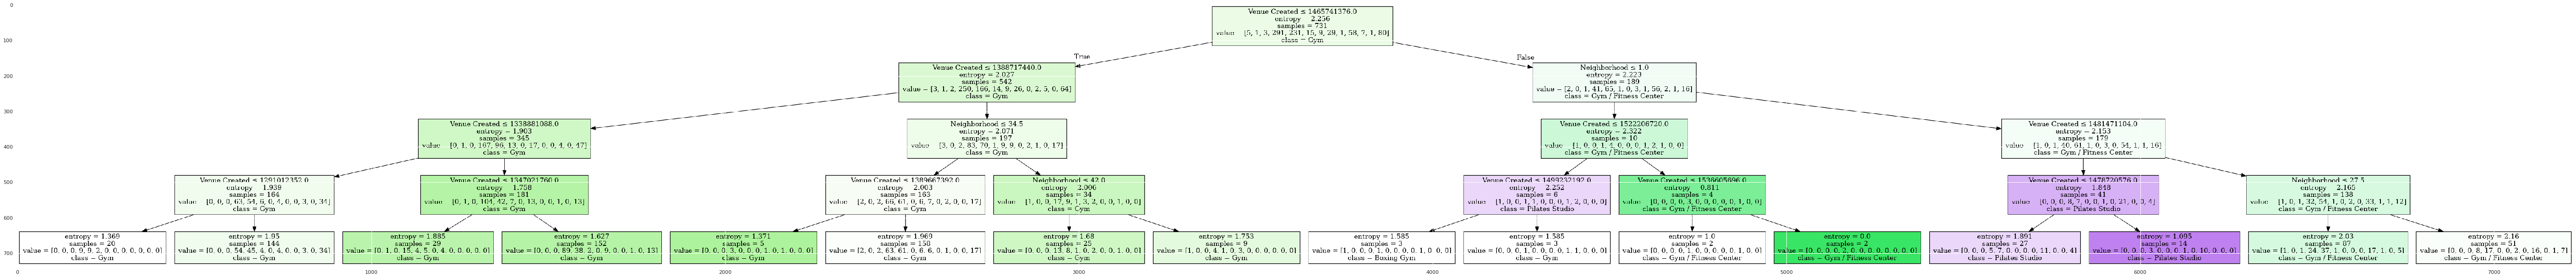

In [39]:
dot_data = StringIO()
filename = "cat_tree.png"
featureNames = ('Venue Created', 'Neighborhood')
targetNames = all_venues["Venue Category"].unique().tolist()
out=tree.export_graphviz(CatTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 400))
plt.imshow(img,interpolation='nearest')

### Let's repeat this for venues except Gym and Gym Fitness Center

In [40]:
all_venues_reg= all_venues.loc[(all_venues['Venue Category']!='Gym')&(all_venues['Venue Category']!='Gym / Fitness Center')][['Venue Created','Neighborhood']].values
#labelling
le_neighborhood = preprocessing.LabelEncoder()
le_neighborhood.fit(all_venues['Neighborhood'].unique())
all_venues_reg[:,1] = le_neighborhood.transform(all_venues_reg[:,1]) 
#setting results
y = all_venues.loc[(all_venues['Venue Category']!='Gym')&(all_venues['Venue Category']!='Gym / Fitness Center')]["Venue Category"]
#setting test and train sets
X_trainset, X_testset, y_trainset, y_testset = train_test_split(all_venues_reg, y, test_size=0.3, random_state=3)
#accuracy test

MDs=20
mean_acc = np.zeros((MDs-1))

for i in range (1,20):
    CatTree2 = DecisionTreeClassifier(criterion="entropy", max_depth = i)
    CatTree2.fit(X_trainset,y_trainset)
    y_predict = CatTree2.predict(X_testset)
    mean_acc[i-1]=accuracy_score(y_testset, y_predict)
    
mean_acc

array([0.55555556, 0.55555556, 0.57777778, 0.6       , 0.55555556,
       0.51111111, 0.56666667, 0.54444444, 0.52222222, 0.53333333,
       0.52222222, 0.53333333, 0.52222222, 0.52222222, 0.53333333,
       0.52222222, 0.51111111, 0.53333333, 0.53333333])

### Deep=4 seems suitable for the model

In [41]:
CatTree2 = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
CatTree2.fit(X_trainset,y_trainset)
y_predict = CatTree.predict(X_testset)

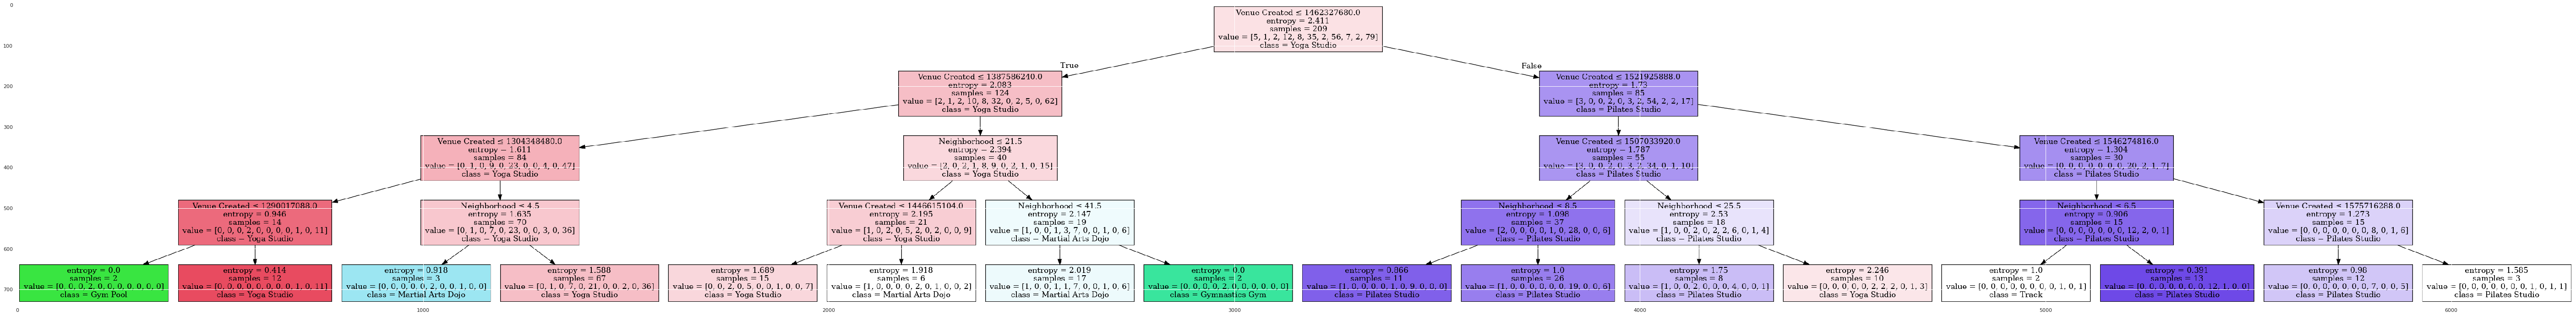

In [42]:
dot_data = StringIO()
filename = "cat_tree2.png"
featureNames = ('Venue Created', 'Neighborhood')
targetNames = all_venues.loc[(all_venues['Venue Category']!='Gym')&(all_venues['Venue Category']!='Gym / Fitness Center')]["Venue Category"].unique().tolist()
out=tree.export_graphviz(CatTree2,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 400))
plt.imshow(img,interpolation='nearest')

In [43]:
dates=np.arange(30)
df_caddebostan=pd.DataFrame(columns={'Neighborhood','Date','Result'})
neighborhood_code=8 #8 is caddebostan's code

for i in range (1,31):
    #timestamp for Sep2020 days
    dates[i-1]=int(datetime.datetime(2020,9,i,12,0).timestamp())
df_caddebostan['Date']=dates
df_caddebostan['Neighborhood']=neighborhood_code
df_caddebostan['Result']=CatTree2.predict(df_caddebostan[['Date','Neighborhood']].values)

print('{} would be the best choice to open in Caddebostan'.format(df_caddebostan.groupby('Result').sum().index[0]))

Pilates Studio would be the best choice to open in Caddebostan


---

# Conclusion

At first glance, Gyms and Gym fitness center seems to dominate all the regions, however it can’t be neglected the **Yoga Studio, Pilates Studio and Martial Art Dojo** venues have strong trends. According to the trends, **Kadıköy seems one step ahead** for those popular categories. It could be a good advice to follow trends in Kadıköy and apply them in other regions to catch the trend. 2 different ML methods are applied to reach the best results to predict the most profitable investment out of the dataset.

Clustering gives a great overview to see where the deviations for categories are. For example, in *cluster 6*, **Yoga Studio** is the *2nd most common venue*, and it might be good to consider an investment on **Turkali Mah.** neighborhood. The frequency of the Venue Category is the base of the model.

Decision Tree is created based on following features:
- Venue Created : *Date*
- Neighborhood : *Location*
Due to the domination of *Gym* and *Gym Fitness Center* categories, the accuracy of the Decision Tree is *affected*. It tends to locate the result in between those two categories. However, it is acceptable with the dataset except those categories. According to the result of the tree, it could be the best to invest on a *Pilates Studio in Kadikoy-Caddebostan*, in September 2020. Similar predictions can be made using the model.
